In [1]:
import torch
import torchvision
import os
import random

import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image

from transformers import BeitForImageClassification, BeitConfig, BeitFeatureExtractor, \
                         ViTForImageClassification, ViTFeatureExtractor
from PIL import Image

from tqdm import tqdm
from collections import defaultdict

In [2]:
# Check for GPU
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

device

'cuda:0'

In [3]:
class food_set(Dataset):

    def __init__(self, labels_file, img_dir, extractor, transform = None, settype = "train"):
        if settype == "train":
            self.img_labels = pd.read_csv(labels_file, names=['img_name', 'label'], header=1)[:30000]
        elif settype == "val":
            self.img_labels = pd.read_csv(labels_file, names=['img_name', 'label'], header=1)[30000:]
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
                
        features = self.feature_extractor(images=image, 
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])["pixel_values"][0]        
        label = self.img_labels.iloc[idx, 1]       
            
        return features, label

In [4]:
class food_test(Dataset):

    def __init__(self, img_dir, extractor, transform = None):
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        file_name = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        features = self.feature_extractor(images=image, 
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])["pixel_values"][0]
        
        return file_name, features

In [5]:
# Load BEiT
beit = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224")

beit.classifier = torch.nn.Linear(768, 81)

beit.load_state_dict(torch.load("./optimal_models/beit_data_augmented.pth"))
beit.to(device);

D:\ProgramData\Anaconda3\envs\R + Python\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
# Load ViT
vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

vit.classifier = torch.nn.Linear(768, 81)

vit.load_state_dict(torch.load("./optimal_models/ViT_data_aug_locked_sets.pth"))
vit.to(device);

In [12]:
class ensemble(nn.Module):
    
    def __init__(self, BEiT, ViT):
        
        super(ensemble, self).__init__()
        
        self.beit = BEiT
        self.vit = ViT
        
        self.beit.classifier = nn.Identity()
        self.vit.classifier = nn.Identity()
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
        
        # dense layer 1
        self.fc1 = nn.Linear(768+768, 1000)

        # dense layer 2 (Output layer)
        self.classifier = nn.Linear(1000, 81)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)       
        
    def forward(self, image):
        
        x1 = self.beit(image)["logits"]
        x2 = self.vit(image)["logits"]
               
        x = torch.cat((x1, x2), dim=1)
        
        x = self.dropout(x)
        x = self.fc1(F.relu(x))
        x = self.classifier(F.relu(x))
        x = self.softmax(x)
       
        return x

In [13]:
ensemble = ensemble(beit, vit)

ensemble.to(device);

In [14]:
def train_loop(trainloader, valloader, model, criterion, optimizer):
    
    # Train on GPU if available
    model = model.to(device)
    model.train()
    
    # Metadata
    stats = defaultdict(list)
    current_acc = 0
    max_acc = 0
    
    try:
        stats["epoch"].append(0)
        stats["loss"].append(8.7)
        stats["accuracy"].append(1.25)

        for epoch in range(5):
            size = len(trainloader.dataset)

            for batch, (image, label) in enumerate(trainloader):
                # Compute prediction and loss
                image, label = image.to(device), label.to(device)            
                pred = model(image)
                loss = criterion(pred, label)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Print progress
                if batch % 200 == 0:
                    loss, current = loss.item(), batch * len(image)
                    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] epoch: {epoch + 1}")

            # Print performance after current number of epochs
            print(f"Epoch: {epoch + 1}")
            current_acc, avg_loss = test_loop(valloader, model, criterion)

            if current_acc > max_acc:
                PATH = f'./ensemble.pth'
                torch.save(model.state_dict(), PATH)
                max_acc = current_acc

            # Store metadata
            stats["epoch"].append(epoch + 1)
            stats["accuracy"].append(current_acc)
            stats["loss"].append(avg_loss)

            # Plot progress
            fig, ax1 = plt.subplots()

            color = "tab:blue"
            ax1.set_xlabel("Epoch")
            ax1.set_ylabel("Loss", color=color)
            ax1.plot(stats["epoch"], stats["loss"], color=color)
            ax1.tick_params(axis="y", labelcolor=color)

            ax2 = ax1.twinx()

            color = "tab:orange"
            ax2.set_ylabel("Accuracy", color=color)
            ax2.plot(stats["epoch"], stats["accuracy"], color=color)
            ax2.tick_params(axis="y", labelcolor=color)
            plt.show()

        return stats
    
    except KeyboardInterrupt:
        return stats


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            test_loss += criterion(pred, label).item()
            correct += (pred.argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return (100 * correct), test_loss

In [15]:
# CrossEntropyLoss and SGD optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ensemble.parameters(), lr = 0.01, momentum = 0.9)
# optimizer = optim.Adam(ensemble.parameters(), lr=0.00001)

In [16]:
img_dir = "./AML_project/data/train_set/train_set"
labels = "./AML_project/data/train_labels.csv"

transform = transforms.Compose(
                    [transforms.RandomApply([transforms.ColorJitter()]),
                     transforms.RandomApply([transforms.RandomAffine(180)]),
                     transforms.RandomHorizontalFlip()])

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

In [17]:
trainset = food_set(labels, img_dir, feature_extractor, transform = transform, settype = "train")
valset = food_set(labels, img_dir, feature_extractor, settype = "val")

# Create a DataLoader with the data
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=8, shuffle=True, num_workers=0)

In [18]:
test_set = food_test("./AML_project/data/test_set/test_set", feature_extractor)
testloader = DataLoader(test_set, batch_size = 8)

len(test_set)

7653

loss: 4.484857  [    0/30000] epoch: 1
loss: 2.021559  [ 1600/30000] epoch: 1
loss: 4.270358  [ 3200/30000] epoch: 1
loss: 3.396354  [ 4800/30000] epoch: 1
loss: 3.521563  [ 6400/30000] epoch: 1
loss: 3.900926  [ 8000/30000] epoch: 1
loss: 3.577565  [ 9600/30000] epoch: 1
loss: 2.345327  [11200/30000] epoch: 1
loss: 3.148907  [12800/30000] epoch: 1
loss: 2.377322  [14400/30000] epoch: 1
loss: 3.301033  [16000/30000] epoch: 1
loss: 3.135596  [17600/30000] epoch: 1
loss: 2.564212  [19200/30000] epoch: 1
loss: 3.292595  [20800/30000] epoch: 1
loss: 3.122515  [22400/30000] epoch: 1
loss: 3.302952  [24000/30000] epoch: 1
loss: 3.230280  [25600/30000] epoch: 1
loss: 1.655823  [27200/30000] epoch: 1
loss: 3.501533  [28800/30000] epoch: 1
Epoch: 1
Test Error: 
 Accuracy: 39.1%, Avg loss: 2.492979 



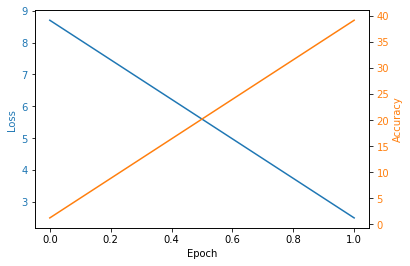

loss: 2.246133  [    0/30000] epoch: 2


In [ ]:
stats = train_loop(trainloader, valloader, ensemble, criterion, optimizer)

In [23]:
df_stats = pd.DataFrame(stats)
df_stats.to_csv("./ensemble.csv")

In [ ]:
# PATH = './transfered_beit.pth'
# torch.save(beit.state_dict(), PATH)

beit.load_state_dict(torch.load("../../other_beit_optimal.pth"))
beit.to(device)

In [24]:
test_results = {"img_name" : [], "label": []}

for file_name, image in tqdm(testloader):
    X = image.to(device)
    pred = ensemble(X).argmax(1)
    
    test_results["img_name"] += file_name
    test_results["label"] += [int(i) for i in pred.cpu()]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 957/957 [05:38<00:00,  2.82it/s]


In [25]:
test_df = pd.DataFrame(test_results)

test_df.head()

,img_name,label
0,test_1.jpg,15
1,test_10.jpg,45
2,test_100.jpg,23
3,test_1000.jpg,29
4,test_1001.jpg,10


In [26]:
test_df.to_csv("./submissions/submission_ensemble_2.csv", index=False)